# U21 Health Sciences Group 2024 Annual Meeting
---
**PLENARY 2**\
Artificial Intelligence: Revolutionizing Healthcare with Large Language Models

**Hands-On Workshop**\
Trustworthy Generative AI: Improving routine care through application of Retrieval-augmented generation of clinical guidelines

---

💡 Before starting:
1. Please save a copy of this codebook to your local drive via "**File**" > "**Save a copy in Drive**" and start working in this copy.
2. This notebook needs a GPU to run properly. Please make sure to check the selected <font color='green'>GPU</font> via the main menu "**Runtime**" > "**Change runtime type**" and switch the runtime if needed to T4 GPU.

---

Currently, you have a [Jupyter](https://jupyter.org/) notebook open which is hosted on Google Colaboratory. Unlike static pages, this environment is interactive, allowing you to write and execute code in Python and other languages. These are the two main cell types you'll encounter:

* Markdown Cells: Formatted text containing the information regarding the workshops, these cells render text seamlessly within the notebook when executed and are formatted.
* Code Cells: These contain executable code, and their output is displayed directly below. Such a box is marked by a [ ] in front of it and colored light grey.
---

&nbsp;&nbsp;&nbsp;&nbsp;Let's get ready! Run the code below by clicking on the play button to install the packages we'll be using.

⚠️ **This might take several minutes.** In the meantime, dive into the next section for the introduction to this workshop.

---

In [ ]:
%%capture
!pip install --upgrade --quiet langchain langchain-community langchain_huggingface langchainhub langchain-chroma unstructured
!pip install --upgrade --quiet torch torchvision torchaudio transformers bitsandbytes accelerate sentencepiece

# Introduction
Within this hands-on workshop, you will create a retrieval-augmented generation (RAG) solution to answer guideline-related medical questions. Specifically in this workshop, we will use the [guidelines](https://academic.oup.com/eurheartj/article/42/36/3599/6358045) of the European Society of Cardiology (ESC) for heart failure, a condition where the heart is unable to efficiently pump blood throughout the body. The idea during this workshop is to provide the information of the guidelines to the LLM to improve question answering within the specific context of the guidelines.

**Expected learning points:**
-	Explain the concepts of Retrieval-Augmented Generation (RAG) and generative Large Language Models (LLMs).
-	Understand how RAG and LLMs can be used to answer clinical questions while specifically considering clinical guidelines.
-	Identify the strengths and limitations of using RAG and LLMs for clinical information retrieval.
-	Gain practical experience using RAG and LLM tools to answer questions related to the ESC Guidelines.


# 1. Large Language Models (LLMs)

LLMs are a type of artificial intelligence (AI) that can understand and generate human-like text. They are called "large" because they have been trained on vast amounts of text data and contain billions of parameters (numbers), which are the internal settings that the model adjusts during training to learn patterns in the data.


## 1.1 How does an LLM work?
At its fundamental level, an LLM is a complex statistical model that learns to predict the next word in a sequence based on the words that came before it. For example, if you start a sentence with "The sky is," the model might predict the next word could be "blue" or "clear." By stringing together predictions, these models can generate coherent paragraphs, write code, translate languages, and much more.

LLMs are built using neural networks, specifically a type of architecture known as a [Transformer](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture), which is highly effective for processing sequences of data, like text. The power of these models comes from their ability to learn from vast amounts of text and generalize to a wide variety of language tasks.

## 1.2 How are LLMs Trained?
Training an LLM involves two main steps:

**Pre-training:** The model is first trained on a massive dataset (like books, websites, and articles) to predict the next word in a sentence. During this process, the model learns grammar, facts about the world, and some reasoning abilities. For example, the model might learn that "Amsterdam" is a city and that "Einstein" was a scientist.

**Fine-tuning:** After pre-training, the model may undergo fine-tuning, where it is further trained on a smaller, more specific dataset, often with human feedback. This helps the model become more accurate and aligned with specific tasks, like answering questions or writing summaries.


## 1.3 Parameters?

The number of parameters in an LLM is crucial. Parameters are like the "knobs" the model adjusts during training to get better at predicting words. More parameters generally mean the model can capture more complex patterns, but it also requires more computational resources to train and run. Small LLMs might have millions of parameters. Large LLMs like GPT-4 have hundreds of billions of parameters.

## 1.4 Examples of LLMs

**Open-Source**
- Llama (developed by Meta): The latest version is 3.1, [Llama 3.1](https://ai.meta.com/blog/meta-llama-3-1/) and comes in 8B, 70B and—for the first time—405B parameters
- Mistral (developed by Mistral AI): [Mistral Nemo 12B parameters, Mistral 7B and Mixtral 8x22B](https://huggingface.co/mistralai)
- Gemma (Google): The latest version is 2. [Gemma 2](https://blog.google/technology/developers/google-gemma-2/) comes in 9B and 27B parameters

**Proprietary LLMs:**
- [GPT-4](https://openai.com/chatgpt/): Developed by OpenAI, one of the most well-known LLMs, with an estimated 1 trillion paramters
- [Gemini](https://gemini.google.com/) (developed by Google)
- [Mistral Large](https://mistral.ai/news/mistral-large/) (developed by Mistral AI): Known for being efficient and powerful, Mistral has been making waves in the LLM landscape

## 1.5 Practical Applications
LLMs have a wide range of applications, including:

- Chatbots: Creating virtual assistants that can handle customer inquiries.
- Content Creation: Generating articles, blogs, and social media posts.
- Code Writing: Assisting developers in writing and debugging code.
- Translation: Automatically translating text between languages.
- Sentiment Analysis: Understanding opinions and sentiments from text data.

# 2. What is Retrieval Augmented Generation, or RAG ?

Think of LLMs as really smart students who learned from a lot of available text material online. They can discuss many things, but the knowledge is limited to the content of what was included in the training of the LLM, including also the point in time to which information was included. This is called the '**knowledge cutoff**' of an LLM.  If you want the LLMs to also take into account information not in the included texts, like **private data** or **recent events**,  you need to provide the LLM with these extra materials. **RAG (Retrieval Augmented Generation)** is like feeding LLMs relevant articles or notes to help them answer your questions better.

Consider for example ChatGPT 3.5, with its knowledge cutoff of January 2022, wouldn't be aware of the recent FDA approval for the new drug for hypertension, Tryvio. See below the response of ChatGPT when the question "What is Tryvio?" is used as a **prompt**. Although ChatGPT has been **fine-tuned** to respond with "I don't know" in such cases, it may **hallucinate** as well. In case of hallucinations, the LLM provides an output which is coherent and grammatically correct but contains information which is incorrect or does not make sense. LLM hallucination poses a significant threat in healthcare. Thus, both through hallucinations and the inclusion of limited training material, LLMs can generate unreliable information or treatment recommendations based on flawed assumptions, potentially leading to misdiagnosis, delayed treatment, and compromised patient safety.

RAG incorporates external (here in the image from wikipedia), reliable information to ground the LLM's outputs. This approach significantly reduces hallucinations and improves the overall quality and accuracy of the generated text.


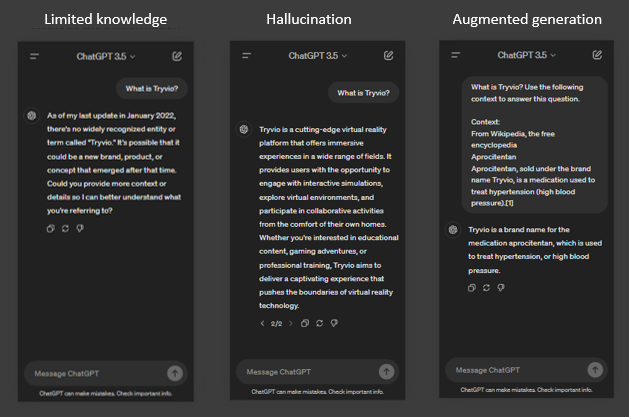

# 3. RAG architecture


A typical RAG architecture consists of two key components: **indexing** & **retrieval and generation**, indicated in the figure below. In the next section, the two components, are explained with the python code implementations using [LangChain](https://www.langchain.com/).

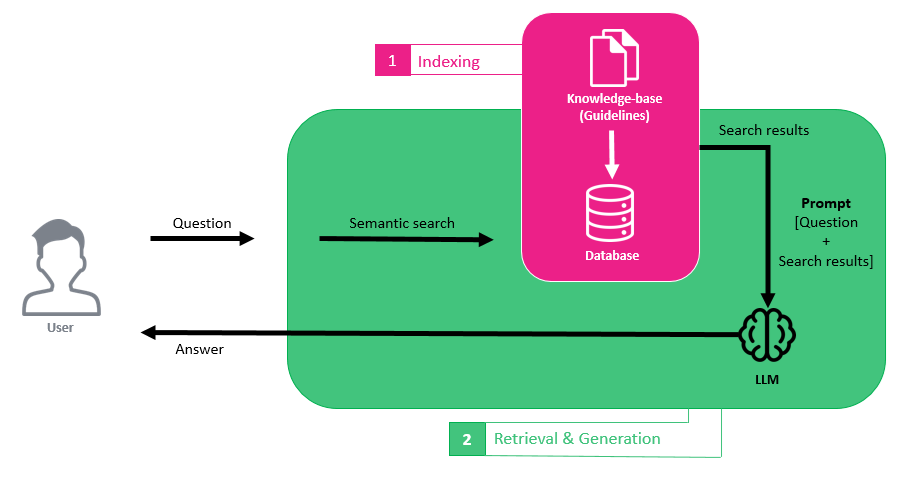

## 3.1 Indexing

In RAG, indexing means the process of organizing the required text data in a way that allows the RAG system to quickly find the most relevant pieces of information for a given question. In this way, a local library is created where RAG can identify the sections which contain the information addressed in the question, instead of having the complete text.

Indexing involves 3 steps:
- Load the data (here the ESC guidelines for heart failure), hereafter called a **document**.
- Split the document into pieces of text called **chunks**.
- Convert the chunks into so-called vectors, and store them in a database.

### 3.1.1 Load the data
The part of code will load the ESC guidelines for heart failure. As we stated before, this is just one document. Additional documents can be loaded, for example more guidelines, but for this workshop, we will just work with one.

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import UnstructuredURLLoader

loader = UnstructuredURLLoader(["https://raw.githubusercontent.com/nomandormosh/u21-workshop-2024/main/ehab368.txt"])
docs = loader.load()

print("Number of documents: ", len(docs)) # Get the total number of documents
print(docs[0].page_content[:200]) # Prints the first 200 characters of the document

### 3.1.2 Splitting the document into chunks of text
The purpose of this step is to to break down a large document into smaller, more manageable pieces. This makes it easier to search and process the information, especially when working with LLMs which can only handle limited amounts of text at once.

Imagine you have a really long story. It's so long that it's hard to find specific information quickly. In this case, you might break it up into smaller chapters or sections. That's basically what happens when splitting the document.

There are many ways to acheive this. The following code will split the document into 250 character long pieces, with a 50-character overlap between consecutive chunks. This setup ensures that the text is split in chunks of 250 characters, but also has overlapping pieces of around 50 characters each, which can help preserve context between chunks (see the overlap between chunk #99 and #100 below).

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
doc_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)
chunked_documents = doc_splitter.split_documents(docs)

print("Total number of chunks: ", len(chunked_documents))   # Total chunks
print("Chunk #99:\n", chunked_documents[99].page_content)   # Prints the content of the chunk at index 99
print("Chunk #100:\n", chunked_documents[100].page_content)   # Prints the content of the chunk at index 100

### 3.1.3 Text-to-vector & storage
Once the text chunks are created, these chunks are converted into numbers to allow the computer to understand the text. This is called text-to-vector conversion, thereby translating from human language to computer language. Each text chunk gets a special code, or vector (sequence of numbers). This vector represents the meaning of the chunk of text. Imagine each chunk is a fruit, and the vector is a number that describes its taste, color, and size.

**Embeddings** are those numbers. They are mathematical representations of words or sentences in a numerical space. Each number corresponds to a different aspect of the word or sentence.

Let's illustrate this with an example. Imagine that we have 4 sentences:
- *Amsterdam's population is over 800,000 people.*
- *Amsterdam has many canals and bike paths.*
- *Tulips are a famous symbol of Amsterdam.*
- *Amsterdam is the capital of the Netherlands.*

And we have one question: *How many people live in Amsterdam?*

After mapping these sentences into vectors, we can plot a 2d graph to represent them and show the relation between the texts, as shown in the figure below. We would expect these sentences to co-exist near each other becuase they are semantically similar, as they are all talking about Amsterdam. However, we can see that Chunk 1 is closest related to the question, as it also indicates the number of people.

In reality, embeddings have many more dimensions (often hundreds or thousands) to capture the nuances of language. Sentences with similar meanings will be closer together in this high-dimensional space.

Why do this? When we want the computer to find information, the computer can quickly look at the vectors instead of reading the whole text. For example, if we want to find the most sementaclly similar sentence or chunk to the question "How many people live in Amsterdam?", then we just find the one with the shortest distance to the question as indicated with the green arrow.

Finally, the created vectors are stored in a vector database that can be used for search and retreival later on. To create the vectors for our selected document and store them in the vector database, run the code below.

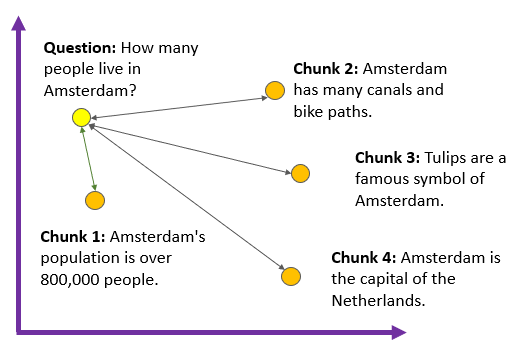



In [ ]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model_name = "NeuML/pubmedbert-base-embeddings" # Model ID for the embedder. You may choose any model you prefer.
embeddings = None
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': False}
)

# Embed our chunks and store in the vector database
vectorstore = Chroma.from_documents(documents=chunked_documents, embedding=embeddings)

After creating the vector database, the database, single vectors and chunks corresponding to a vector can be inspected! Run the code below.

In [ ]:
print("Total emmbedded chunks: ", len(vectorstore.get()["documents"])) # Does the number match our total chunks?

print("Chunk #1: ", vectorstore.get()["documents"][0]) # Prints chunk #1

# Get embedding vector for chunk #1
chunk_id = vectorstore.get()["ids"][0]
chunk_vector = vectorstore._collection.get(ids=[chunk_id], include=['embeddings'])["embeddings"]
print("Vector's dimensions: ", len(chunk_vector[0]))
print("The first 10 dimensions: ", chunk_vector[:10])

We now have our vector database ready for search. Let's try to search for top 3 chunks that are semantically similar to the sentence "Acute pulmonary oedema?" by calculating the distance of the different chunks to the sentence.

*Note: this search requires the input sentence to be mapped into a vector. We don't have to do this by our self as the vector database will do this under the hood.*

In [ ]:
sentence = "Acute pulmonary oedema?"
results = vectorstore.similarity_search_with_score(sentence, k=3)

for i, item in enumerate(results):
    print(f"{i+1}- Distance {item[1]} - {item[0].page_content}\n")

Cool! Based on this search and by identifying the vector(s) with the least distance, the identified text will serve as our retreival. To summarize, in this search, the answer to a particular question or sentence is found by comparing the vectors and the most relevant results based on the semantic search is returned as output.

## 3.2 Retrieval and generation

After setting up the vector database (section 3.1), the next step is to:  
*   load the desired LLM to process the question and generate the answer
*   define the prompt template which will be provided to the LLM

#### 3.2.1 Load the LLM
We will use the [instructed version of Llama 3.1 8B](https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct). As indicated in the name, it consists of 8B parameters. This would make it impossible to get loaded in this Colab environment as it requires 8B * 4 bytes = 32 GB to be loaded in full precision, instead of the 15 GB available here. To solve this, we will use a quantized version of the model. **Quantization** is a technique in which each parameter is mapped to a smaller set of discrete finite values and requires less RAM at the expense of losing some quality of the LLM, but allowing us to use it in the current environment.

In [ ]:
import torch
from langchain_huggingface import HuggingFacePipeline

# Load 4bit quant of the LLM
model_id = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"
hf = None
hf = HuggingFacePipeline.from_model_id(
    model_id=model_id,
    device=None,
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 256,
                     "temperature": 0.00001,
                     "repetition_penalty": 1.1,
                     "return_full_text": False},
)

Let's try to ask this LLM a question without grounding it with context from the guidelines.

*Note: We will ask the same question later on using our RAG solution to compare the results.*

In [ ]:
print(hf.invoke("What is the incidence of HF in Europe?"))

#### 3.2.2 Prompt template
After choosing the LLM, the template of the prompt should be formalized. The designed template (provided in the code box below) consists of an instruction where we give the LLM the task, the question we want to address, and the context from the retreived chunks which are supposed to be semantically similar to the question. After the finalization of the template, different questions can be posed to the LLM (section 4).

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join("- " + doc.page_content for doc in docs)

retriever = vectorstore.as_retriever(search_kargs={"k": 5}) # k is the number of retreived relevant chunks of documents that we want to have

template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.

Question: {question}

Context: {context}

Answer:"""

prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | hf
    | StrOutputParser()
)

# 4. RAG in action

#### 4.1 Simple question

Let's ask first a simple factual question about the prevelance of heart failure in Europe.

In [ ]:
question_1 = "What is the incidence of HF in Europe?"
print(rag_chain.invoke(question_1))

The answer is fine but not complete. The guidelines say "Currently, the incidence of HF in Europe is about 3/1000 person-years (all age-groups) or about 5/1000 person-years in adults.". So, 5/1000 specificly refers to the incidence in adults.

Let's inspect the prompt generated by our RAG solution for this particular question to see if we can explain this issue.

In [ ]:
from langchain_core.callbacks import BaseCallbackHandler
from typing import Any, Dict, List


class CustomHandler(BaseCallbackHandler):
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        formatted_prompts = "\n".join(prompts)
        print(f"Prompt:\n{formatted_prompts}")

# You can call this line of code to inspect the prompt
print(rag_chain.invoke("What is the incidence of HF in Europe?", config={"callbacks": [CustomHandler()]}))

In the prompt, the chunk provided in the context is turnicated "Currently, the incidence of HF in Europe is about 3/1000 person-years (all age-groups) or about 5/1000". This is why the LLM couldn't give a perfect answer.

Recall that we splitted the document into chunks using specific parameters (chunk_size and chunk_overlap). We need to increase the chunk_size to allow longer chunked text in the context. This is one of the tuning parameters if we want to tweak our RAG.

#### 4.2 Out-of-scope question
What if we ask a question completely unrelated to the guidelines of heart failure?

In [ ]:
question_2 = "What is the GDP of the Netherlands?"
print(rag_chain.invoke(question_2))

Good, the LLM recognized that this question is completely unrelated to the provided context.

#### 4.3 Complex questions
Most likely, users of the LLM will want to also retrieve more complex information from the LLM and thus pose questions containing information which should be considered when providing the answer. For example, the treatment of patients with heart failure and other co-morbidities can differ from general heart failure treatment.

In [ ]:
question_4 = "How to treat heart failure with diabetes?"
print(rag_chain.invoke(question_4))

In the same context, also different types of heart failure may require different medical treatment.

In [ ]:
question_5 = "What medications recommended for patients with HFrEF?"
print(rag_chain.invoke(question_5))

Both question 4 and 5 provide important information in the question which should be addressed in the answer to the question. However, another aspect in LLMs is the formulation of the question, as these can be posed using different wording. Given that our search is semantically based, we should anticipate similar results.

In [ ]:
question_6 = "What is the standard pharmacological treatment for patients with HFrEF?"
print(rag_chain.invoke(question_6))

Our semantic search is performing as expected. However, it's important to remember that the effectiveness of semantic search heavily relies on the chosen (embedding) model. Different wordings of the same query might yield varying results due to the model's limitations in capturing semantic nuances. To illustrate this, try rephrasing the question in the box above (question_6) and observe the outcomes.

#### 4.4 Additional complex questions

In [ ]:
question_7 = "How to diagnose HFrEF?"
print(rag_chain.invoke(question_7))

In [ ]:
question_8 = """A 65-year-old male with a history of hypertension, diabetes, and prior myocardial infarction
presents with worsening dyspnea, fatigue, and ankle swelling. Exam shows JVD, an S3 heart sound, and pitting edema.
Investigations reveal an ejection fraction of 35%, cardiomegaly, and elevated BNP.
What is his heart failure type according to the ESC guidelines?"""
print(rag_chain.invoke(question_8))

As demonstrated by the outputs, the current RAG setup is insufficient for answering these queries. This limitation can be attributed to several factors:

* Long question: Long questions pose a significant challenge due to the difficulty of accurately capturing their semantic meaning within a fixed-size vector. This ambiguity hinders effective information retrieval.
* Information Dispersion: Relevant information might be scattered across the document, resulting in retrieved text fragments that may not fully address the query's essence or might be irrelevant altogether.
* Complex Reasoning: The answers to some questions require advanced reasoning capabilities that exceed the current limitations of LLMs.

# 5. Now it's your turn! Let's put the RAG solution to the test.

Here are the [ESC HF guidelines](https://academic.oup.com/eurheartj/article/42/36/3599/6358045): feel free to browse them and craft your questions to see how well the RAG system performs in handling them.

In [ ]:
user_question = ""
print(rag_chain.invoke(user_question))

# 6. [Optional] Tweaking your RAG pipeline

While RAG offers a promising approach to mitigating hallucinations, it introduces its own set of challenges that can significantly impact its performance. Here are some key factors to consider:

1. Chunking and Text Splitting: The length and overlap of text chunks directly influence the quality of information retrieved. Finding the optimal balance is crucial.
2. Embedding Model Selection: Choosing the right embedding model is essential. While the chosen model might excel with medical text, exploring [alternatives](https://huggingface.co/sentence-transformers) could potentially lead to further improvements. (models)
3. LLM Choice: The underlying LLM can also play a role. Experimenting with different models such as [Mistral 0.3](unsloth/mistral-7b-instruct-v0.3-bnb-4bit) or [gemma 2](https://huggingface.co/unsloth/gemma-2-9b-bnb-4bit) might yield better results.

It's important to note that there are many advanced RAG techniques beyond the scope of this workshop that can further enhance performance.

### Balancing precision and context in document chunking/splitting
When splitting the documents into chunks, there is a tradeoff between accuracy and comprehensiveness. Smaller chunks can yield more precise representations of their content, but at the risk of losing contextual information. Conversely, larger chunks preserve context but may sacrifice the detailed understanding achievable through smaller divisions.

We will experiment with a hybrid text splitting strategy that incorporates both smaller and larger text units. The heart failure guidelines is structured with HTML tags. Similar to our initial experiment, we will divide the text into smaller chunks (chunk_size=250, chunk_overlap) and convert them into vector embeddings for efficient searching. However, to enrich the search results before LLM processing, we will retrieve the entire HTML section encompassing the relevant chunk.

#### 6.1 Let's first prepare our guideline text and split it into sections

In [ ]:
from langchain_text_splitters import HTMLHeaderTextSplitter
import re

headers_to_split_on = [
        ("h2", "Header 2"),
        ("h3", "Header 3"),
        ("h4", "Header 4"),
    ]

def preprocess(text: str) -> str:
    # enclose text below h tags with p tags
    paragraphs = re.findall(r'^(?!<[^>]+>|[\s\[\]]).+', text, re.MULTILINE)
    for paragraph in paragraphs:
        text = text.replace(paragraph, f'<p>{paragraph}</p>')

    # Add 2 new lines to fix concatenated paragraphs
    pattern1 = r"][\w]"
    pattern2 = r"\.[^\d\s\[\]]"
    combined_pattern = pattern1 + "|" + pattern2
    items = re.findall(combined_pattern, text, re.MULTILINE)
    for item in items:
        if item not in [".g", ".e"]:  #for e.g. en i.e.
            text = text.replace(item, item[0] + "\n" + item[1])

    # Remove references placeholders
    ref_pattern = r"\['([a-zA-Z0-9-]+-B\d+)'(?:, '[a-zA-Z0-9-]+-B\d+')*\]"
    text = re.sub(ref_pattern, "", text, re.MULTILINE)

    return text

html_splitter = HTMLHeaderTextSplitter(headers_to_split_on)
new_docs = html_splitter.split_text(preprocess(docs[0].page_content))
new_docs[10:15]

As you can see from the output above, we now have the contents of the sections including their headings.

#### 6.2 Split into chunks, link to parent section, map to vector, and store in vector database

In [ ]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

child_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50) # Similar to our initial experiment
store = InMemoryStore() # a dictionary to store the id of the chunk and the corresponding document id
new_vectorstore = Chroma(embedding_function=embeddings)
new_vectorstore.reset_collection()

new_retriever = ParentDocumentRetriever(
        vectorstore=new_vectorstore,
        docstore=store,
        child_splitter=child_splitter,
        childK=20,
        parentK=5,
        search_kwargs={"k": 6} # Retreive 4 full sections
    )

# Perform chunking, linking each chunk to it's parent section, and finally map to vector and store in a vector database
new_retriever.add_documents(new_docs, ids=None)

Let's see how the chunks look like when we search for our question

In [ ]:
new_vectorstore.similarity_search("How to diagnose HFrEF?")

And, what would be the corresponding retreived sections to be given to the LLM for this question?

In [ ]:
retrieved_docs = new_retriever.invoke("How to diagnose HFrEF?")
retrieved_docs


#### 6.3 Test it out

In [ ]:
parent_rag_chain = (
    {"context": new_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | hf
    | StrOutputParser()
)

In [ ]:
print(parent_rag_chain.invoke("How to diagnose HFrEF?"))

The response seems to be improved compared to the answer of the question previously given before in section 5.

# 7. Summary

In this workshop, we introduced the concepts of RAG and LLMs and their potential application in healthcare, specifically for answering guideline-related medical questions.


- **LLMs:** These are powerful AI models trained on vast amounts of text data. They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way. However, they can also suffer from hallucinations, where they provide incorrect or misleading information, especially when dealing with limited or outdated knowledge.
- **Knowledge Cutoff:** LLMs have a limited timeframe of knowledge based on the data they are trained on. Information not included in the training data, like recent medical advancements, might not be reflected in the LLM's responses.
- **RAG:** RAG addresses the limitations of LLMs by incorporating relevant external information sources into the question-answering process. This helps to ground the LLM's outputs and reduce hallucinations, leading to more accurate and reliable answers.
- **Building a RAG System:** We explored constructing a RAG system using LangChain, a Python library. The system involves two main components:
  - *Indexing and Retrieval:* This involves creating a searchable database of relevant text chunks extracted from the guidelines. When a question is asked, the system retrieves the most relevant chunks based on their semantic similarity.
  - *Generation:* The retrieved information is then provided to an LLM along with the question. The LLM uses this context to generate a comprehensive answer.
- **RAG optimization:** Although RAG has the potential of improving LLMs outputs, it brings it's own challanges. Many factors can impact the performance, such as chunking size, embedding model selection, and embedding model choice.

To sum up, RAG provides an opportunity to enhance the accuracy and reliability of LLMs, especially in fields like healthcare where precision is important. By grounding LLMs with external, up-to-date sources, RAG helps mitigate issues like hallucinations and outdated information. The retrieval model is crucial in RAG systems, with success depending on its optimization and data quality. The LLM's role is simply to summarize, making its choice less important than the quality of retrieval.